In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load chlorophyll data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('2003-01','2023-07'))

chl = ds.chlor_a
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

# Function to calculate mean values over specified months
def calculate_monthly_mean(data, months):
    data_selected = data.sel(time=np.in1d(data['time.month'], months))
    data_clm = data_selected.groupby('time.month').mean('time')
    return data_clm.mean('month')

average_chl = calculate_monthly_mean(chl, [6, 7, 8, 9, 10, 11])

# Load current data
fn2 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds_currents = xr.open_dataset(fn2)
ds_currents = ds_currents.sel(time=slice('2003-01', '2023-07'))

ds_currents = ds_currents.sel(latitude=slice(-19, 30))
ds_currents = ds_currents.sel(longitude=slice(41, 120))

# Rename latitude and longitude coordinates
ds_currents = ds_currents.rename({'latitude': 'lat', 'longitude': 'lon'})

# Select surface currents (depth=0)
ds_currents = ds_currents.isel(depth=0)
u = ds_currents.uo
v = ds_currents.vo
u_average_chl = calculate_monthly_mean(u, [6, 7, 8, 9, 10, 11])
v_average_chl = calculate_monthly_mean(v, [6, 7, 8, 9, 10, 11])

# Function to plot the quiver
def uv_plot(ax, ur, vr):
    # Determine the dimensions of the u and v arrays
    n_dims = ur.shape

    # Create a grid of (x, y) coordinates matching the dimensions of u and v
    x, y = np.meshgrid(ur.lon, ur.lat)

    U = ur
    V = vr

    i = 9
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='darkred', alpha=0.7, headwidth=6, scale=1.1, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    # Add color to continents with scale='10m'
    ax.add_feature(cfeature.NaturalEarthFeature(
        category='physical', name='land', facecolor='gray', edgecolor='black', scale='10m'
    ))
    # Add coastlines
    ax.coastlines(resolution='10m', linewidth=1)

    # Add longitude and latitude to the axes and set custom formatters
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False  # Disable labels on top
    gl.ylabels_right = False  # Disable labels on the right
    gl.xlocator = mticker.MultipleLocator(base=20)  # Set longitude interval to 20 degrees
    gl.ylocator = mticker.MultipleLocator(base=10)  # Set latitude interval to 10 degrees
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add a quiver key
    ax.quiverkey(q, X=0.90, Y=1.02, U=0.2, label='0.2 m/s', labelpos='E')

    return

# Load and preprocess chlorophyll data for pIOD composite
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)

chl = ds.chlor_a
chl = chl.sel(time=slice('1997-09','2023-07'))
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

def anomcal(data, a, b, c):
    clm = data.groupby('time.month').mean('time')
    data = data.groupby('time.month') - clm
    data = data.sel(time=np.in1d(data['time.month'], [a, b, c]))
    return data

chl_son = anomcal(chl, 9, 10, 11)

# Load and preprocess SST data
fn2 = './sst.mnmean.nc'
ds = xr.open_dataset(fn2)
sst = ds.sst
sst = sst.sel(time=slice('1997-09', '2023-07'))

def detrend(sst, dim, deg=1):
    p = sst.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(ds[dim], p.polyfit_coefficients)
    return sst - fit

def dmi(sst, lat1, lat2, lon1, lon2):
    sst = sst.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    clm = sst.groupby('time.month').mean('time')
    an_sst = sst.groupby('time.month') - clm
    an_sst = an_sst.mean(('lat', 'lon'))
    an_sst = detrend(an_sst, dim='time', deg=1)
    return an_sst

wio = dmi(sst, 10, -10, 50, 70)
eio = dmi(sst, 0, -10, 90, 110)
obs_dmi = wio - eio

def iodcomp(index, data, c):
    STD = index.sel(time=np.in1d(index['time.month'], [6, 7, 8, 9, 10, 11]))
    STD = STD.std()
    index = index.sel(time=np.in1d(index['time.month'], [9, 10, 11]))
    index = np.where(np.abs(index) < (STD * 1), np.nan, index)
    nd = data.shape
    ds = np.empty(nd)
    for i in range(nd[0]):
        if c == 0:
            ds[i] = np.where(index[i] > 0, data[i], np.nan)
        else:
            ds[i] = np.where(index[i] < 0, data[i], np.nan)
    ds = np.nanmean(ds, axis=0)
    ds = xr.DataArray(ds, dims=['lat', 'lon'], coords=dict(lat=data.lat, lon=data.lon))
    return ds

chl_piod_compson = iodcomp(obs_dmi, chl_son, 0)

# Load and preprocess surface currents data for pIOD composite
fn3 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds = xr.open_dataset(fn3)
ds = ds.sel(time=slice('1997-09','2023-07'))
ds = ds.sel(latitude=slice(-19,30))
ds = ds.sel(longitude=slice(41,120))
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
ds = ds.isel(depth=0)
ds = ds.drop_vars('depth')

u = ds.uo
v = ds.vo

u_son = anomcal(u, 9, 10, 11)
v_son = anomcal(v, 9, 10, 11)

u_piod_compson = iodcomp(obs_dmi, u_son, 0)
v_piod_compson = iodcomp(obs_dmi, v_son, 0)

# Function to plot quiver for second subplot
def uv_plot(ax, ur, vr):
    n_dims = ur.shape
    x, y = np.meshgrid(ur.lon, ur.lat)
    U = ur
    V = vr
    i = 9
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='darkred', alpha=0.7, headwidth=6, scale=0.95, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    ax.quiverkey(q, X=0.90, Y=1.02, U=0.2, label='0.1 m/s', labelpos='E')
    return

# Plotting code for the first subplot
plt.figure(figsize=(10, 16))

# First subplot
plt.subplot(2, 1, 1)  # 2 rows, 1 column, subplot 1
ax1 = plt.gca()
contour1 = average_chl.plot.contourf(ax=ax1, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', 
                                    cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax1, u_average_chl, v_average_chl)
plt.title('a) Mean state - Chl and Surface Currents [JJASON]', loc='left')

# Plotting code for the second subplot
# Second subplot
plt.subplot(2, 1, 2)  # 2 rows, 1 column, subplot 2
ax2 = plt.gca()
contour2 = chl_piod_compson.plot.contourf(ax=ax2, levels=10, extend='both', vmin=-0.3, vmax=0.3, cmap='PiYG', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax2, u_piod_compson, v_piod_compson)
plt.title('b) pIOD Composite - Chl and Surface Currents [SON]', loc='left')

plt.tight_layout()  # Adjust layout to prevent overlap

# Show the plot
plt.show()


C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\1247652478.py:135: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\1247652478.py:135: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\1247652478.py:135: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

Error in callback <function _draw_all_if_interactive at 0x000001B75AB0CFE0> (for post_execute):


ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

ValueError: Axes should be an instance of GeoAxes, got <class 'matplotlib.axes._axes.Axes'>

<Figure size 1000x1600 with 2 Axes>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load and preprocess chlorophyll data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(lat=slice(31, -21), lon=slice(39, 121))
ds = ds.sel(time=slice('1997-09', '2023-07'))

# Function to calculate mean values over specified months
def calculate_monthly_mean(data, months):
    data_selected = data.sel(time=np.in1d(data['time.month'], months))
    data_clm = data_selected.groupby('time.month').mean('time')
    return data_clm.mean('month')

chl = ds.chlor_a
chl_mean = calculate_monthly_mean(chl, [6, 7, 8, 9, 10, 11])

def anomcal(data, a, b, c):
    clm = data.groupby('time.month').mean('time')
    data = data.groupby('time.month') - clm
    data = data.sel(time=np.in1d(data['time.month'], [a, b, c]))
    return data

chl_son = anomcal(chl, 9, 10, 11)

# Load and preprocess SST data
fn2 = './sst.mnmean.nc'
ds_sst = xr.open_dataset(fn2)
sst = ds_sst.sst.sel(time=slice('1997-09', '2023-07'))

def detrend(sst, dim, deg=1):
    p = sst.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(ds_sst[dim], p.polyfit_coefficients)
    return sst - fit

def dmi(sst, lat1, lat2, lon1, lon2):
    sst = sst.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    clm = sst.groupby('time.month').mean('time')
    an_sst = sst.groupby('time.month') - clm
    an_sst = an_sst.mean(('lat', 'lon'))
    an_sst = detrend(an_sst, dim='time', deg=1)
    return an_sst

wio = dmi(sst, 10, -10, 50, 70)
eio = dmi(sst, 0, -10, 90, 110)
obs_dmi = wio - eio

def iodcomp(index, data, c):
    STD = index.sel(time=np.in1d(index['time.month'], [6, 7, 8, 9, 10, 11])).std()
    index = index.sel(time=np.in1d(index['time.month'], [9, 10, 11]))
    index = np.where(np.abs(index) < (STD * 1), np.nan, index)
    ds = np.where((index[:, None, None] > 0) if c == 0 else (index[:, None, None] < 0), data, np.nan)
    ds = np.nanmean(ds, axis=0)
    return xr.DataArray(ds, dims=['lat', 'lon'], coords=dict(lat=data.lat, lon=data.lon))

chl_piod_compson = iodcomp(obs_dmi, chl_son, 0)

# Load and preprocess surface currents data
fn3 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds_currents = xr.open_dataset(fn3)
ds_currents = ds_currents.sel(time=slice('1997-09', '2023-07'))
ds_currents = ds_currents.rename({'latitude': 'lat', 'longitude': 'lon'})
ds_currents = ds_currents.sel(lat=slice(-19, 30), lon=slice(41, 120)).isel(depth=0)

u = ds_currents.uo
v = ds_currents.vo

u_mean = calculate_monthly_mean(u, [6, 7, 8, 9, 10, 11])
v_mean = calculate_monthly_mean(v, [6, 7, 8, 9, 10, 11])

u_son = anomcal(u, 9, 10, 11)
v_son = anomcal(v, 9, 10, 11)

u_piod_compson = iodcomp(obs_dmi, u_son, 0)
v_piod_compson = iodcomp(obs_dmi, v_son, 0)

# Function to plot the quiver
def uv_plot(ax, ur, vr):
    x, y = np.meshgrid(ur.lon, ur.lat)
    q = ax.quiver(x[::9, ::9], y[::9, ::9], ur[::9, ::9], vr[::9, ::9], color='darkred', alpha=0.7, headwidth=6, scale=1.1, scale_units='inches', headlength=5, width=0.002, transform=ccrs.PlateCarree())
    ax.add_feature(cfeature.NaturalEarthFeature(category='physical', name='land', facecolor='gray', edgecolor='black', scale='10m'))
    ax.coastlines(resolution='10m', linewidth=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MultipleLocator(base=20)
    gl.ylocator = mticker.MultipleLocator(base=10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.quiverkey(q, X=0.90, Y=1.02, U=0.2, label='0.2 m/s', labelpos='E')
    return

# Create a figure with 2 subplots (2 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.1)

# First subplot: Mean state - Chl and Surface Currents [JJASON]
ax1 = axes[0]
contour1 = chl_mean.plot.contourf(ax=ax1, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax1, u_mean, v_mean)
ax1.set_title('a) Mean state - Chl and Surface Currents [JJASON]', loc='left')

# Second subplot: pIOD Composite - Chl and Surface Currents [SON]
ax2 = axes[1]
contour2 = chl_piod_compson.plot.contourf(ax=ax2, levels=10, extend='both', vmin=-0.3, vmax=0.3, cmap='PiYG', cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax2, u_piod_compson, v_piod_compson)
ax2.set_title('b) pIOD Composite - Chl and Surface Currents [SON]', loc='left')

# Show the plot
plt.show()


C:\Users\thivi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\3289433888.py:59: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)


ValueError: operands could not be broadcast together with shapes (78,1,1) (75,196,316) () 

C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\3440237790.py:131: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\3440237790.py:131: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\AppData\Local\Temp\ipykernel_6548\3440237790.py:131: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xla

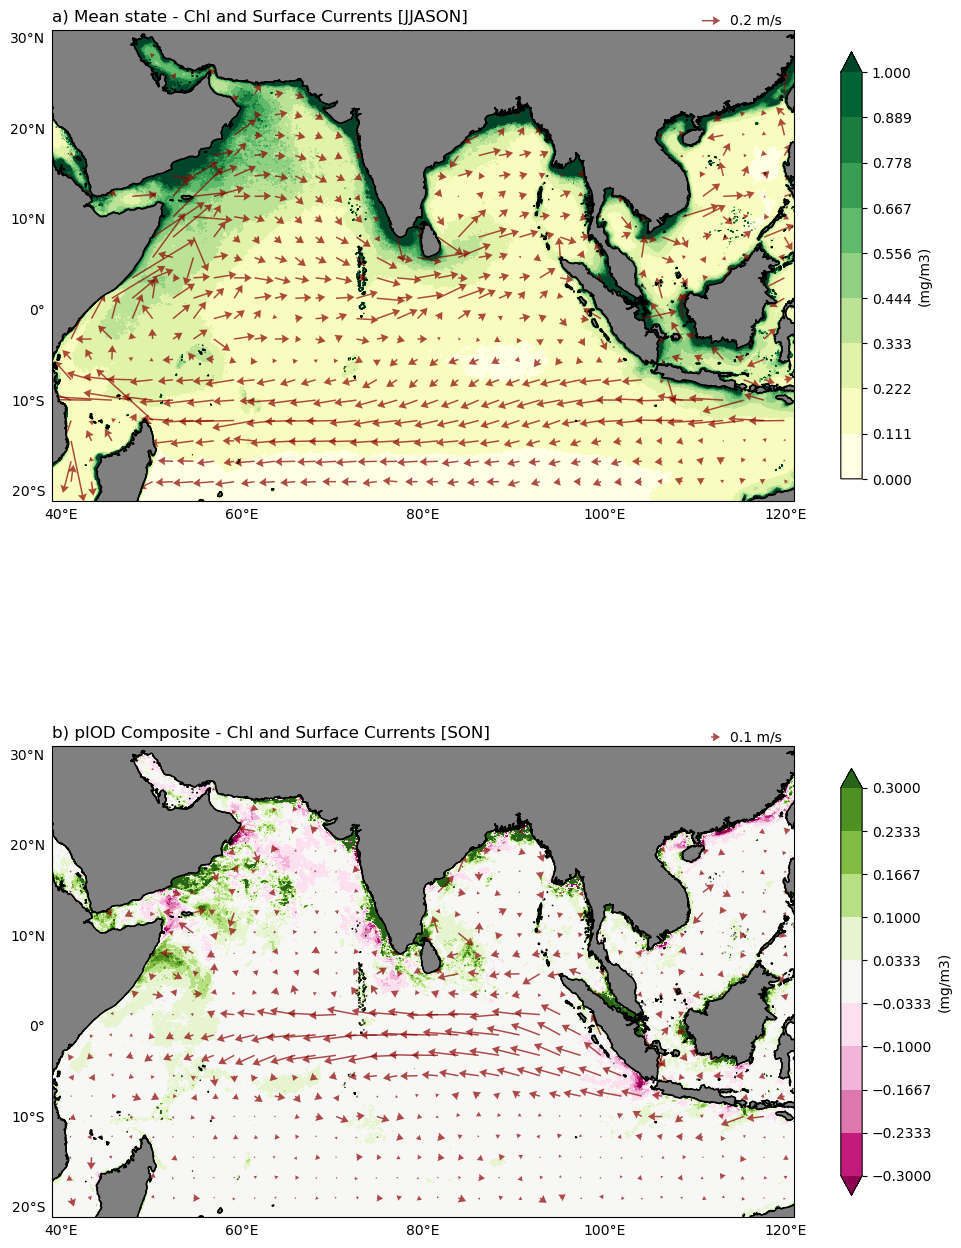

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load chlorophyll data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('2003-01','2023-07'))

chl = ds.chlor_a
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

# Function to calculate mean values over specified months
def calculate_monthly_mean(data, months):
    data_selected = data.sel(time=np.in1d(data['time.month'], months))
    data_clm = data_selected.groupby('time.month').mean('time')
    return data_clm.mean('month')

average_chl = calculate_monthly_mean(chl, [6, 7, 8, 9, 10, 11])

# Load current data
fn2 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds_currents = xr.open_dataset(fn2)
ds_currents = ds_currents.sel(time=slice('2003-01', '2023-07'))

ds_currents = ds_currents.sel(latitude=slice(-19, 30))
ds_currents = ds_currents.sel(longitude=slice(41, 120))

# Rename latitude and longitude coordinates
ds_currents = ds_currents.rename({'latitude': 'lat', 'longitude': 'lon'})

# Select surface currents (depth=0)
ds_currents = ds_currents.isel(depth=0)
u = ds_currents.uo
v = ds_currents.vo
u_average_chl = calculate_monthly_mean(u, [6, 7, 8, 9, 10, 11])
v_average_chl = calculate_monthly_mean(v, [6, 7, 8, 9, 10, 11])

# Function to plot the quiver
def uv_plot(ax, ur, vr, scale_key=0.2):
    # Determine the dimensions of the u and v arrays
    n_dims = ur.shape

    # Create a grid of (x, y) coordinates matching the dimensions of u and v
    x, y = np.meshgrid(ur.lon, ur.lat)

    U = ur
    V = vr

    i = 9
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='darkred', alpha=0.7, headwidth=6, scale=1.1, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    # Add color to continents with scale='10m'
    ax.add_feature(cfeature.NaturalEarthFeature(
        category='physical', name='land', facecolor='gray', edgecolor='black', scale='10m'
    ))
    # Add coastlines
    ax.coastlines(resolution='10m', linewidth=1)

    # Add longitude and latitude to the axes and set custom formatters
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False  # Disable labels on top
    gl.ylabels_right = False  # Disable labels on the right
    gl.xlocator = mticker.MultipleLocator(base=20)  # Set longitude interval to 20 degrees
    gl.ylocator = mticker.MultipleLocator(base=10)  # Set latitude interval to 10 degrees
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add a quiver key
    ax.quiverkey(q, X=0.90, Y=1.02, U=scale_key, label=f'{scale_key} m/s', labelpos='E')

    return

# Load and preprocess chlorophyll data
chl = ds.chlor_a
chl = chl.sel(time=slice('1997-09','2023-07'))
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

def anomcal(data, a, b, c):
    clm = data.groupby('time.month').mean('time')
    data = data.groupby('time.month') - clm
    data = data.sel(time=np.in1d(data['time.month'], [a, b, c]))
    return data

chl_son = anomcal(chl, 9, 10, 11)

# Load and preprocess SST data
fn2 = './sst.mnmean.nc'
ds = xr.open_dataset(fn2)
sst = ds.sst
sst = sst.sel(time=slice('1997-09', '2023-07'))

def detrend(sst, dim, deg=1):
    p = sst.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(ds[dim], p.polyfit_coefficients)
    return sst - fit

def dmi(sst, lat1, lat2, lon1, lon2):
    sst = sst.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    clm = sst.groupby('time.month').mean('time')
    an_sst = sst.groupby('time.month') - clm
    an_sst = an_sst.mean(('lat', 'lon'))
    an_sst = detrend(an_sst, dim='time', deg=1)
    return an_sst

wio = dmi(sst, 10, -10, 50, 70)
eio = dmi(sst, 0, -10, 90, 110)
obs_dmi = wio - eio

def iodcomp(index, data, c):
    STD = index.sel(time=np.in1d(index['time.month'], [6, 7, 8, 9, 10, 11])).std()
    index = index.sel(time=np.in1d(index['time.month'], [9, 10, 11]))
    index = np.where(np.abs(index) < (STD * 1), np.nan, index)
    nd = data.shape
    ds = np.empty(nd)
    for i in range(nd[0]):
        if c == 0:
            ds[i] = np.where(index[i] > 0, data[i], np.nan)
        else:
            ds[i] = np.where(index[i] < 0, data[i], np.nan)
    ds = np.nanmean(ds, axis=0)
    ds = xr.DataArray(ds, dims=['lat', 'lon'], coords=dict(lat=data.lat, lon=data.lon))
    return ds

chl_piod_compson = iodcomp(obs_dmi, chl_son, 0)

# Load and preprocess surface currents data
fn3 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds = xr.open_dataset(fn3)
ds = ds.sel(time=slice('1997-09','2023-07'))
ds = ds.sel(latitude=slice(-19,30))
ds = ds.sel(longitude=slice(41,120))
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'})
ds = ds.isel(depth=0)
ds = ds.drop_vars('depth')

u = ds.uo
v = ds.vo

u_son = anomcal(u, 9, 10, 11)
v_son = anomcal(v, 9, 10, 11)

u_piod_compson = iodcomp(obs_dmi, u_son, 0)
v_piod_compson = iodcomp(obs_dmi, v_son, 0)

# Create a figure with Cartopy projection and two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Subplot 1: Mean state - Chl and Surface Currents [JJASON]
contour1 = average_chl.plot.contourf(ax=ax1, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', 
                                     cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax1, u_average_chl, v_average_chl, scale_key=0.2)
ax1.set_title('a) Mean state - Chl and Surface Currents [JJASON]', loc='left')

# Subplot 2: pIOD Composite - Chl and Surface Currents [SON]
contour2 = chl_piod_compson.plot.contourf(ax=ax2, levels=10, extend='both', vmin=-0.3, vmax=0.3, cmap='PiYG', 
                                          cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})
uv_plot(ax2, u_piod_compson, v_piod_compson, scale_key=0.1)
ax2.set_title('b) pIOD Composite - Chl and Surface Currents [SON]', loc='left')

# Adjust space between subplots
plt.subplots_adjust(hspace=0.1)

# Show the plot
plt.tight_layout()
plt.show()
